In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
img=Image.open("../input_data/img_20.jpg")
img=img.resize((32,32))

In [98]:
class ConvLayer():
    
    def __init__(self,layerDims):
        
        self.dims=layerDims

class FCLayer():
    
    def __init__(self,currentSize):
        
        self.layerSize=currentSize

class CNN():
    
    def __init__(self,nConvLayers,nFClayers,Convdims,FCdims,ActFunc):
        
        self.nConvLayers=nConvLayers
        self.nFClayers=nFClayers
        
        self.ConvLayers=[]
        self.FClayers=[]
        
        for i in range(self.nConvLayers+1):
            self.ConvLayers.append(ConvLayer(Convdims[i]))
        
        for i in range(self.nFClayers):
            self.FClayers.append(FCLayer(FCdims[i]))
   
        for i in range(1,self.nConvLayers+1):
            height,width,channels,layerType=self.ConvLayers[i].dims
            if layerType=="conv":
                self.ConvLayers[i].Weights=np.random.randn(height,width,self.ConvLayers[i-1].dims[2],channels)
                self.ConvLayers[i].Bias=np.zeros((1,1,1,channels))
                self.ConvLayers[i].Param={"stride":1,"layerType":"conv"}
                self.ConvLayers[i].layerType="conv"
                self.ConvLayers[i].ActFunc=getattr(self,ActFunc)
            else:
                self.ConvLayers[i].Param={"stride":2,"layerType":"pool","filterSize":height}
        
        for i in range(1,self.nFClayers):
            self.FClayers[i].Weights=np.random.randn(FCdims[i],FCdims[i-1])
            self.FClayers[i].Bias=np.zeros((FCdims[i],1))
            self.FClayers[i].ActFunc=getattr(self,ActFunc)
            
        self.FClayers[-1].ActFunc=getattr(self,"SOFTMAX")
    
    def FCForward(self,X):
        self.FClayers[0].Activations=X
        for i in range(1,self.nFClayers):
            self.FClayers[i].Z=np.dot(self.FClayers[i].Weights,self.FClayers[i-1].Activations)+self.FClayers[i].Bias
            self.FClayers[i].Activations=self.FClayers[i].ActFunc(self.FClayers[i].Z)
        
    def singleConv(self,a_slice,W,b):
        s=np.multiply(a_slice,W)
        Z=np.sum(s)
        Z+=float(b)
        return Z

    def convForward(self,prevA,param,W=None,b=None):
        
        (pHeight,pWidth,pChannels)=prevA.shape
        stride=param["stride"]
        layerType=param["layerType"]
        
        if layerType=="conv": 
            (f,f,pChannels,channels)=W.shape
        else:
            f,channels=param["filterSize"],pChannels
        
        height=int((pHeight-f)/stride)+1
        width=int((pWidth-f)/stride)+1
        
        A=np.zeros((height,width,channels))
        
        for h in range(height):
            for w in range(width):
                for c in range(channels):
                    vStart=h*stride
                    vEnd=vStart+f
                    hStart=w*stride
                    hEnd=hStart+f
                    if layerType=="pool":
                        prevASlice=prevA[vStart:vEnd,hStart:hEnd,c]
                        A[h,w,c]=np.max(prevASlice)
                    else:
                        prevASlice=prevA[vStart:vEnd,hStart:hEnd,:]
                        A[h,w,c]=self.singleConv(prevASlice,W[:,:,:,c],b[:,:,:,c])
        return A
    
    def SOFTMAX(self,x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    def RELU(self,z):
        return np.maximum(z, 0)
    
    def SIGMOID(self,z):
        return 1/(1+np.exp(-z))
    
    def forwardProp(self,img):
        self.ConvLayers[0].Activations=np.array(img).reshape(32,32,1)
        for i in range(1,self.nConvLayers+1):
            if self.ConvLayers[i].Param["layerType"]=="conv":
                self.ConvLayers[i].Z=self.convForward(self.ConvLayers[i-1].Activations,self.ConvLayers[i].Param,self.ConvLayers[i].Weights,self.ConvLayers[i].Bias)
                self.ConvLayers[i].Activations=self.ConvLayers[i].ActFunc(self.ConvLayers[i].Z)
            else:
                self.ConvLayers[i].Activations=self.convForward(self.ConvLayers[i-1].Activations,self.ConvLayers[i].Param)
        X=np.squeeze(self.ConvLayers[-1].Activations).reshape(self.FClayers[0].layerSize,1)
        self.FCForward(X)
        
    def showIMG(self,i):
        print("Image after Layer:",i)
        currentIMG=self.ConvLayers[i].Activations
        print("Dimensions: ",currentIMG.shape)
        filters=currentIMG.shape[-1]
        
        cols=filters//2
        fig, axs = plt.subplots(2,cols)
        for col in range(cols):
            x=Image.fromarray(currentIMG[:,:,col])
            axs[0,col].imshow(x)
        for col in range(cols):
            x=Image.fromarray(currentIMG[:,:,col+cols])
            axs[1,col].imshow(x)

    def showIMG(self,layerNumber):
        nImages=self.ConvLayers[layerNumber].Activations.shape[-1]
        fig=plt.figure()
        for i in range(nImages):
            image=self.ConvLayers[layerNumber].Activations[:,:,i]
            a=fig.add_subplot(1,nImages,i+1)
            plt.imshow(Image.fromarray(image))
        fig.set_size_inches(np.array(fig.get_size_inches())*nImages)
        plt.show()

In [99]:
model=CNN(5,3,[(32,32,1),(5,5,6,"conv"),(2,2,6,"pool"),(5,5,16,"conv"),(2,2,16,"pool"),(5,5,120,"conv")],[120,84,10],"RELU")

In [100]:
model.forwardProp(img)

In [101]:
print("Predicted Value is: ",np.argmax(model.FClayers[-1].Activations))

Predicted Value is:  7


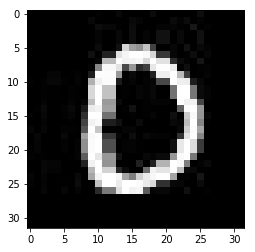

In [102]:
model.showIMG(0)

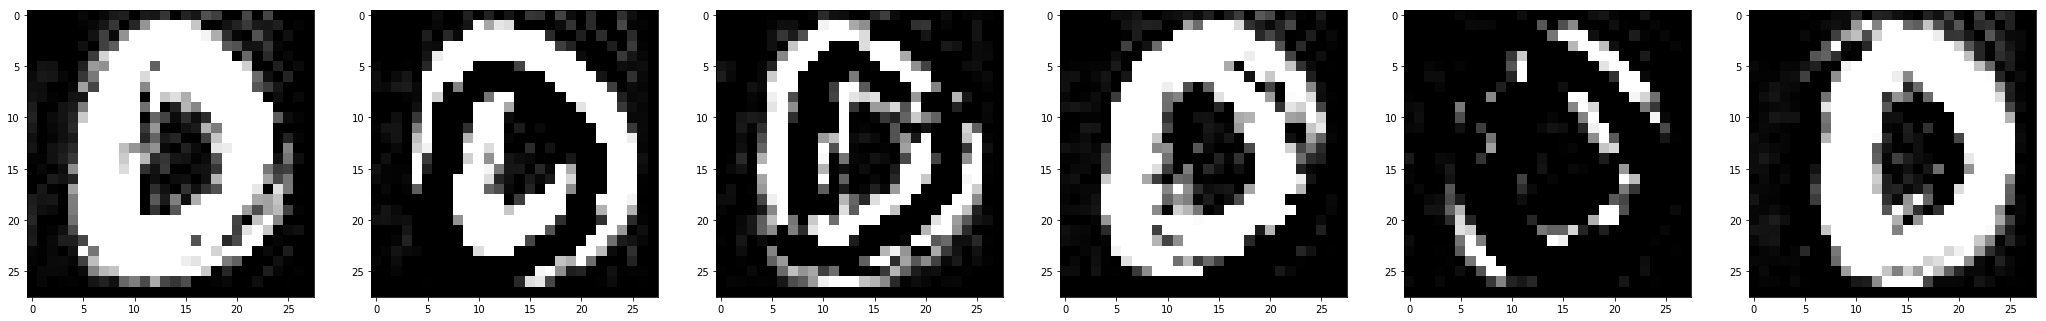

In [103]:
model.showIMG(1)

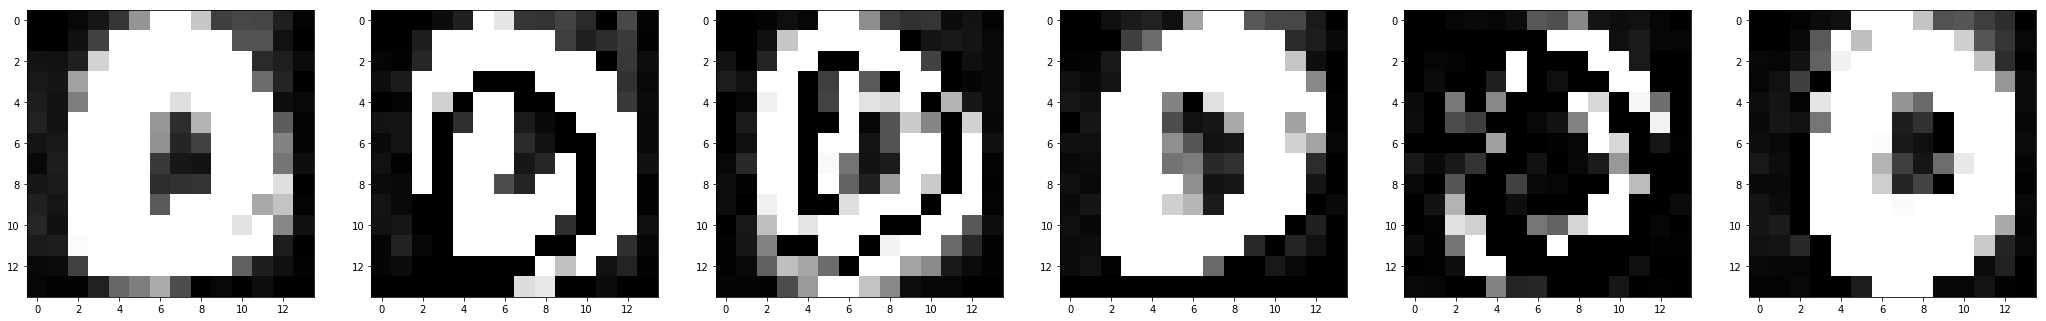

In [104]:
model.showIMG(2)

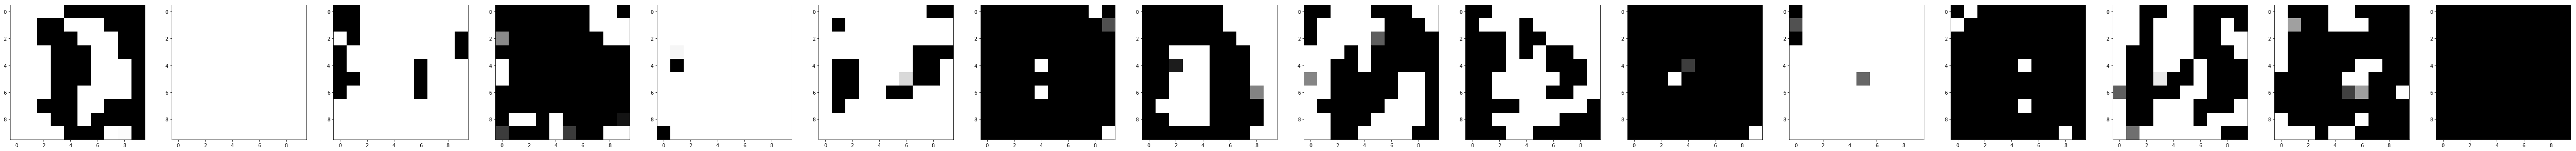

In [105]:
model.showIMG(3)

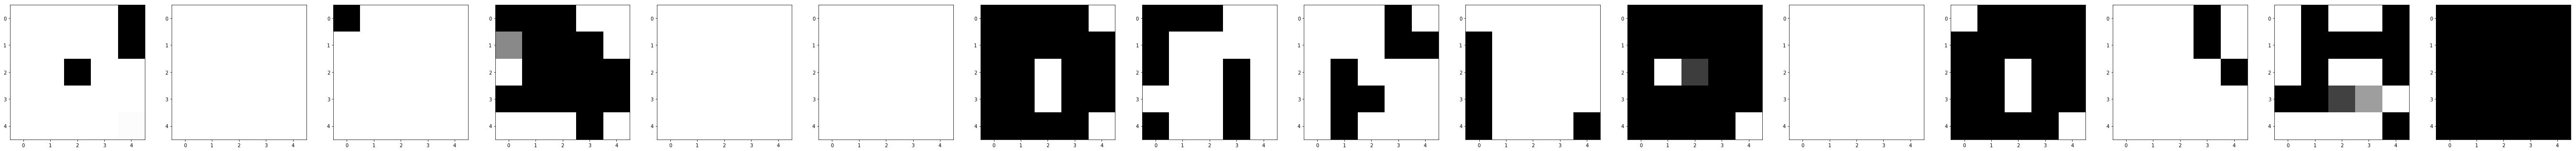

In [106]:
model.showIMG(4)